In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Check that gradients can flow across channel:

In [4]:
channel = CommChannel(size=10, temperature=10, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[0.17203212 0.28408566 0.28843376 0.25544852]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-1.4901161e-09, -2.9802323e-09, -2.9802323e-09, -2.9802323e-09]],
      dtype=float32)>

In [5]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [6]:
NUM_CLASSES = 3
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [7]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [8]:
inputs, targets = generate_train_batch()

In [9]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

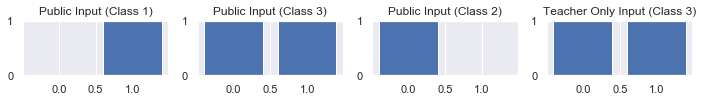

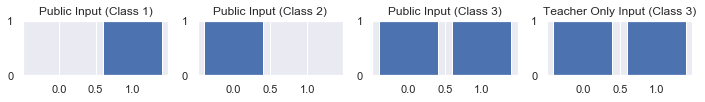

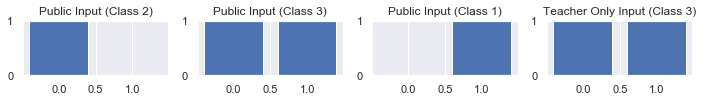

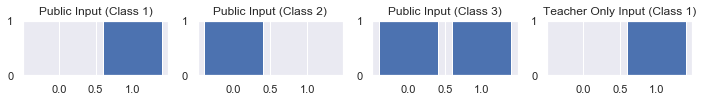

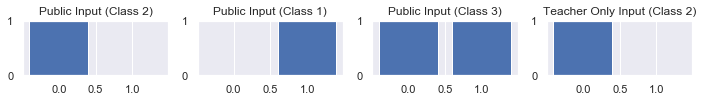

In [10]:
class_labels = list(TRAIN_DATA.keys())

if USE_MNIST:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for i, (ax, inp, tar) in enumerate(zip(axs, inputs, targets)):
        l = tar[row].numpy().argmax() + 1
        if i < NUM_CLASSES:
            ax.set_title(f'Public Input (Class {l})')
        else:
            ax.set_title(f'Teacher Only Input (Class {l})')
        if USE_MNIST:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [11]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[3, 4, 1, 2],
       [1, 3, 0, 2],
       [1, 3, 0, 4],
       [2, 3, 4, 0],
       [3, 0, 2, 4]], dtype=int64)>

## Create Data-Specific Input Encoder

In [12]:
if USE_MNIST:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    AGENT_INPUT_ENCODER = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    AGENT_INPUT_ENCODER = None

CHANNEL_SIZE = 5

### Checking Gradients of Agent Parameters with Respect to Loss Function:

In [13]:
teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
# teacher = experiment.teacher
# student = experiment.student

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student,
                        training=True,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0.5)

    loss = complete_loss_fn(outputs, targets)
#     loss = protocol_diversity_loss(outputs)
#     loss = protocol_entropy(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, student.trainable_variables)

print('Mean Loss:', loss.numpy().mean())

print()

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(student.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

Instructions for updating:
Use tf.identity instead.
Mean Loss: 4.0596294

agent/dense/kernel:0 teacher grad norm: 3.152353048324585
agent/dense/bias:0 teacher grad norm: 2.0506181716918945
agent/lstm/kernel:0 teacher grad norm: 5.2806267738342285
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.9320564270019531
agent/lstm/bias:0 teacher grad norm: 1.091096043586731
agent/dense_1/kernel:0 teacher grad norm: 2.431515693664551
agent/dense_1/bias:0 teacher grad norm: 2.771561622619629

agent/dense_2/kernel:0 student grad norm: 2.626596450805664
agent/dense_2/bias:0 student grad norm: 2.8448472023010254
agent/lstm_1/kernel:0 student grad norm: 4.610038757324219
agent/lstm_1/recurrent_kernel:0 student grad norm: 1.3163797855377197
agent/lstm_1/bias:0 student grad norm: 3.40436053276062
agent/dense_3/kernel:0 student grad norm: 1.9414135217666626
agent/dense_3/bias:0 student grad norm: 3.7897660732269287


In [14]:
complete_loss_fn(outputs, targets)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 2.6773832,  3.2959785,  3.4364116,  2.7101414,  4.214243 ,
        2.662542 , 11.44386  ,  2.665271 ,  2.6982813,  3.603854 ,
        2.6922078,  5.679786 ,  3.9387188,  3.8108792,  2.7373424,
        3.965703 ,  2.714062 ,  3.2453406, 12.559102 ,  5.2626643,
        3.6032848,  3.060552 ,  3.9637883,  2.7362185,  2.857047 ,
        2.6470006,  3.8161795,  2.6564846,  7.97134  ,  2.8425117,
        3.5103927,  4.2295666], dtype=float32)>

In [15]:
teacher.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [16]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, teacher, student,
                    p_mutate=1, 
                    channel_size=CHANNEL_SIZE,
                    kind_mutations=False,
                    training=False)

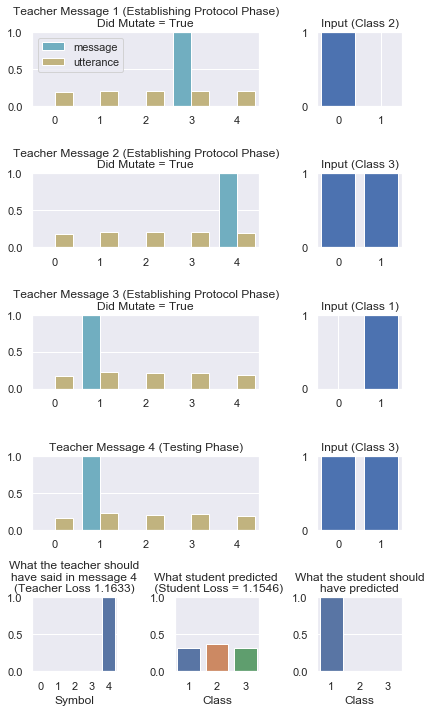

In [17]:
plot_game(inputs, outputs, targets, select_batch=6)

In [18]:
inputs, targets = generate_train_batch()

import unittest.mock as mock
synth_student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, synth_student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 2.1913576126098633
agent/dense/bias:0 teacher grad norm: 2.091416120529175
agent/lstm/kernel:0 teacher grad norm: 3.807896137237549
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.38137906789779663
agent/lstm/bias:0 teacher grad norm: 2.5430259704589844
agent/dense_1/kernel:0 teacher grad norm: 1.5759029388427734
agent/dense_1/bias:0 teacher grad norm: 4.840679168701172


# Run Experiments

In [19]:
def create_only_student_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=teacher_test_message_is_correct,
        name='only_student_experiment'
    )


def create_only_teacher_test_msg_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        loss_fn=student_pred_matches_implied_class,
        name='only_teacher_test_msg_experiment'
    )


def create_only_teacher_create_protocol_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=lambda o, t: protocol_diversity_loss(o),
        name='only_teacher_create_protocol_experiment'
    )

def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn,
        name='other_play_experiment'
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class,
        name='other_play_separate_optimise_experiment'
    )

def create_self_play_experiment(p_mutate=0.3, epochs=40):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        name='self_play_experiment'
    )

def create_mutation_with_temp_annealing_experiment(
    p_mutate=0.3, channel_size=5, epochs=100, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 1.0
    temp_anneal_end_epoch = 50
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
        }
    
    def loss_fn(o, t):
        return combined_loss_fn(o, t, w=0.5)
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=loss_fn,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

def create_mut_temp_direct_loss_experiment(
    p_mutate=0.3, channel_size=5, epochs=250, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 1.0
    temp_anneal_end_epoch = 50
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
#             'stop_gradients_on_final_message': True,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

def create_message_permutation_experiment(epochs=40):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        name='message_permutation_experiment'
    )

def create_message_permutation_is_all_you_need_experiment(epochs=100):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        name='message_permutation_is_all_you_need'
    )

In [23]:
mutation_temp_anneal_exp = create_mutation_with_temp_annealing_experiment()

In [23]:
mutation_temp_anneal_exp.max_epochs = 150

In [ ]:
mutation_temp_anneal_exp.run()

In [ ]:
msg_mut_exp = create_self_play_experiment()

In [ ]:
msg_mut_exp.run()

In [ ]:
exp = mutation_temp_anneal_exp
games_played, test_metrics = exp.run_tests()
test_metrics, exp.get_config()

In [ ]:
permutation_experiment = create_message_permutation_is_all_you_need_experiment(epochs=200)

In [ ]:
permutation_experiment.run()

In [ ]:
games_played, test_metrics = permutation_experiment.run_tests()

In [ ]:
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1, annot=True);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=1)

In [ ]:
exp = mutation_temp_anneal_exp
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(exp.training_history)), 
             y=[item['loss'] for item in exp.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in exp.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * exp.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    if 'error' in metric:
        continue
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=metric,
                 ax=ax)

In [20]:
def protocol_entropy(outputs):
    _, history = outputs
    messages = get_sent_messages(history)

    num_msgs, batch_size, channel_size = tf.shape(messages)

    # arrange protocol matrix columns into rows across 
    # all batches - will be reshaped back later
    protocol_msgs = messages[:-1, :, :]
    protocol_msgs = tf.einsum('ijk->jki', protocol_msgs)
    num_classes = protocol_msgs.shape[-1]
    new_shape = (batch_size*channel_size, num_classes)
    protocol_msgs = tf.reshape(protocol_msgs, new_shape)

    # normalise matrix columns - terminology is backwards because
    # tfp expects each row to be a distribution so the 
    # protocol matrix is transposed
    row_sums = tf.reduce_sum(protocol_msgs, axis=-1)
    row_sums = tf.reshape(row_sums, (tf.shape(row_sums)[0], 1))
    row_sums = tf.repeat(row_sums, num_classes, axis=-1)

    eps = 1e-15 # small value to avoid div by zero 
    probs = eps + protocol_msgs / (row_sums + eps)

    entropy = cce(probs, probs)
    entropy = tf.reshape(entropy, (batch_size, channel_size))
    entropy = tf.reduce_sum(entropy, axis=-1)

    return entropy


def complete_loss_fn(outputs, targets, 
                     w1=1.0, w2=1.0, w3=1.0):
    loss = w1 * teacher_test_message_is_correct(outputs, targets)
    loss = loss + protocol_diversity_loss(outputs)
#     loss = loss + w2 * protocol_entropy(outputs)
    loss = loss + w3 * student_pred_matches_implied_class(outputs, targets)
    return loss

experiment = create_self_play_experiment(epochs=100, p_mutate=0.0)
experiment.get_config()

{'name': 'self_play_experiment',
 'max_epochs': 100,
 'steps_per_epoch': 50,
 'epochs_optimised': 0,
 'play_params': {'channel_size': 5, 'p_mutate': 0.0},
 'test_freq': 5,
 'test_steps': 25,
 'optimiser_config': {'name': 'RMSprop',
  'learning_rate': 0.01,
  'decay': 0.0,
  'rho': 0.9,
  'momentum': 0.0,
  'epsilon': 1e-07,
  'centered': False},
 'optimise_agents_separately': False,
 'loss_fn': 'complete_loss_fn'}

In [21]:
experiment.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 100, 'steps_per_epoch': 50, 'epochs_optimised': 12, 'play_params': {'channel_size': 5, 'p_mutate': 0.0}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:7, Mean Loss: 3.899
Test Loss: 4.543, Ground Truth F1-Score: 0.363, Student Error: 1.101, Teacher Error: 0.442, Protocol Diversity: 0.333, Protocol Entropy: 1.6,
Epoch 1, Time Taken (mm:ss): 0:7, Mean Loss: 2.73
Epoch 2, Time Taken (mm:ss): 0:7, Mean Loss: 2.702
Epoch 3, Time Taken (mm:ss): 0:10, Mean Loss: 1.209
Epoch 4, Time Taken (mm:ss): 0:10, Mean Loss: 1.001
Epoch 5, Time Taken (mm:ss): 0:9, Mean Loss: 1.0
Test Loss: 1.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 

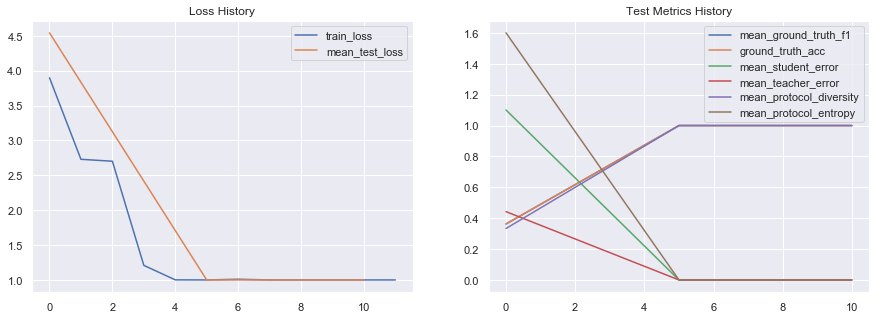

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'] for item in experiment.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in experiment.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * experiment.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=f'{metric}',
                 ax=ax)

In [86]:
history = [
    {'message_from_teacher': [
        [0., 0., 0., 0., 1.], [0., 1., 0., 0., 0.], [0., 0., 1., 0., 0.]
    ]},
    {'message_from_teacher': [
        [0., 0., 0., 0., 1.], [0., 0., 1., 0., 0.], [0., .1, .9, 0., 0.]
    ]},
    {'message_from_teacher': [
        [0., 0., 0., 0., 1.], [0., 0., 0., 1., 0.], [0., 0., 1., 0., 0.]
    ]},
    {'message_from_teacher': [
        [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.]
    ]},
]

In [30]:
tf.metrics.categorical_crossentropy([0.5, 0.5], [0.5, 0.5])**0.5

<tf.Tensor: shape=(), dtype=float32, numpy=0.83255464>

In [89]:
protocol_entropy((None, history))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.0986123e+00, 3.5762795e-07, 1.0974089e+00], dtype=float32)>

In [87]:
protocol_entropy(outputs)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123, 1.0986123,
       1.0986123, 1.0986123], dtype=float32)>

In [23]:
experiment2 = create_self_play_experiment(epochs=100, p_mutate=0.3)

In [29]:
experiment2.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 100, 'steps_per_epoch': 50, 'epochs_optimised': 51, 'play_params': {'channel_size': 5, 'p_mutate': 0.3}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:9, Mean Loss: 3.783
Test Loss: 4.262, Ground Truth F1-Score: 0.35, Student Error: 1.104, Teacher Error: 0.761, Protocol Diversity: 0.461, Protocol Entropy: 0.838,
Epoch 1, Time Taken (mm:ss): 0:12, Mean Loss: 3.783
Epoch 2, Time Taken (mm:ss): 0:12, Mean Loss: 3.738
Epoch 3, Time Taken (mm:ss): 0:11, Mean Loss: 2.702
Epoch 4, Time Taken (mm:ss): 0:12, Mean Loss: 2.625
Epoch 5, Time Taken (mm:ss): 0:10, Mean Loss: 1.346
Test Loss: 1.348, Ground Truth F1-Score: 0.929, Student Error: 0.178, Te

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000243E246CF60>,
      dtype=object)

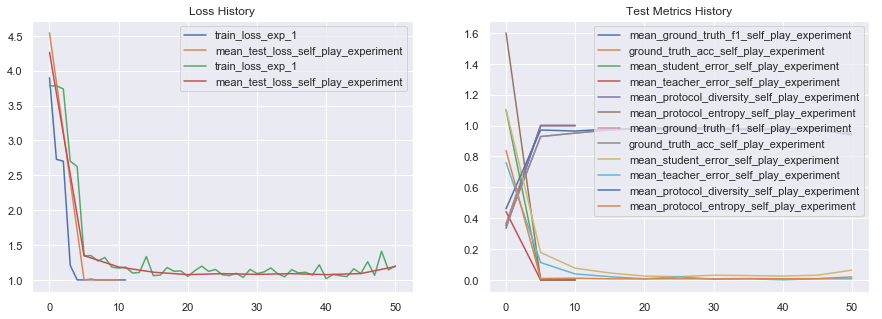

In [30]:
axs = experiment.plot_training_history()
experiment2.plot_training_history(axs=axs)

## Render Model Graph in Tensorboard

In [2]:
# # Set up logging.
# from datetime import datetime
# import tensorboard
# %load_ext tensorboard

# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)

# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [3]:
# %tensorboard --logdir logs

## Analyse Trained Models

In [25]:
games_played, test_metrics = experiment.run_tests()
test_metrics

{'mean_test_loss': 1.0000001192092896,
 'mean_ground_truth_f1': 1.0,
 'ground_truth_acc': 1.0,
 'mean_student_error': 1.1920928955078125e-07,
 'mean_teacher_error': 1.1920928955078125e-07,
 'mean_protocol_diversity': 1.0,
 'mean_protocol_entropy': 7.222239013367687e-35}

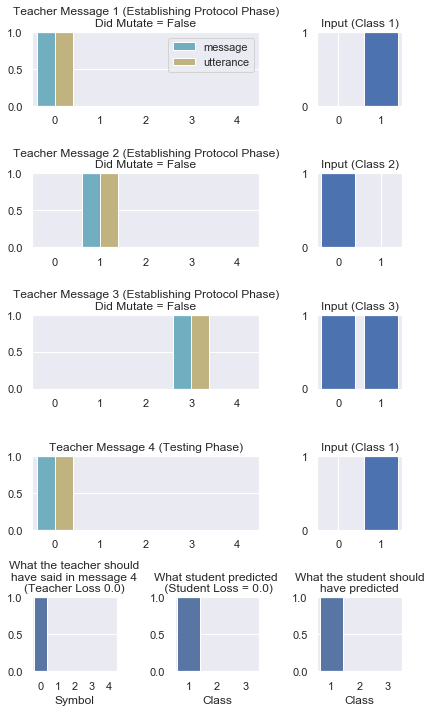

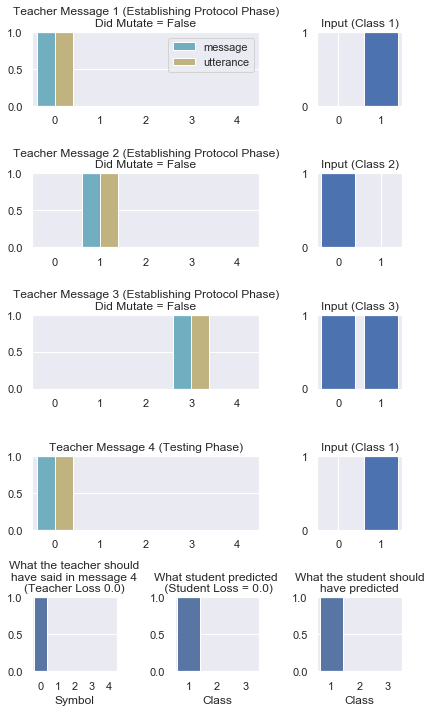

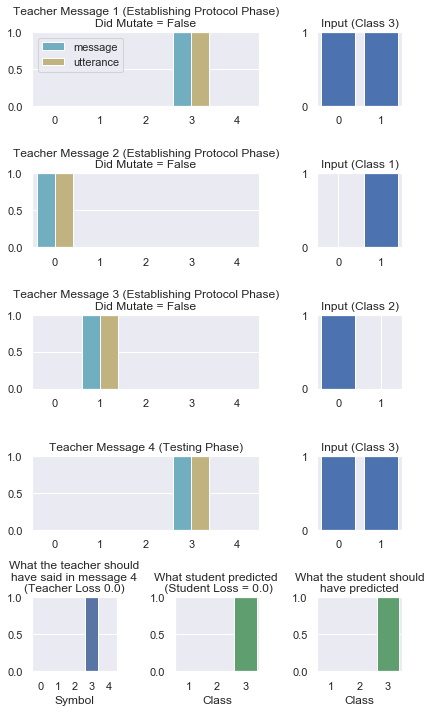

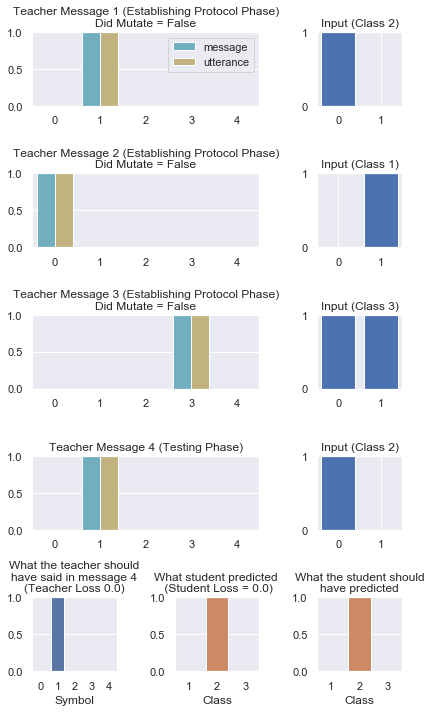

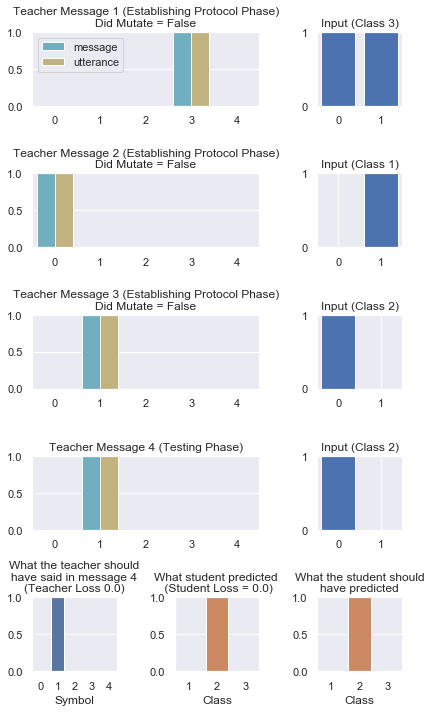

In [26]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

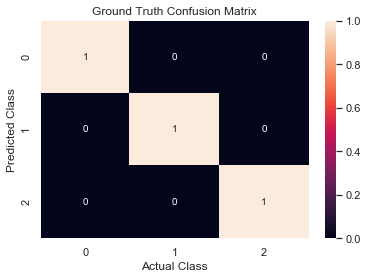

In [27]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

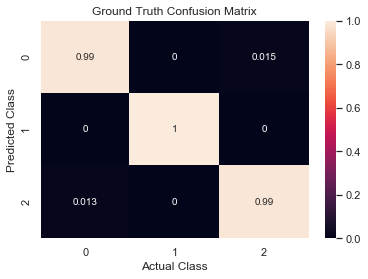

In [32]:
games_played, _ = experiment2.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

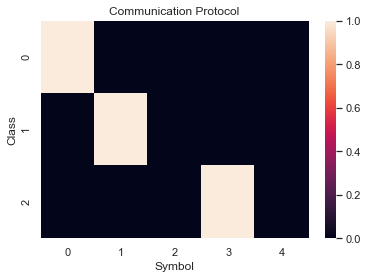

In [28]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

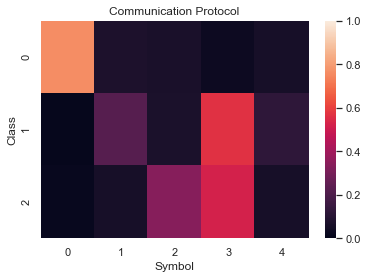

In [31]:
games_played, _ = experiment2.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

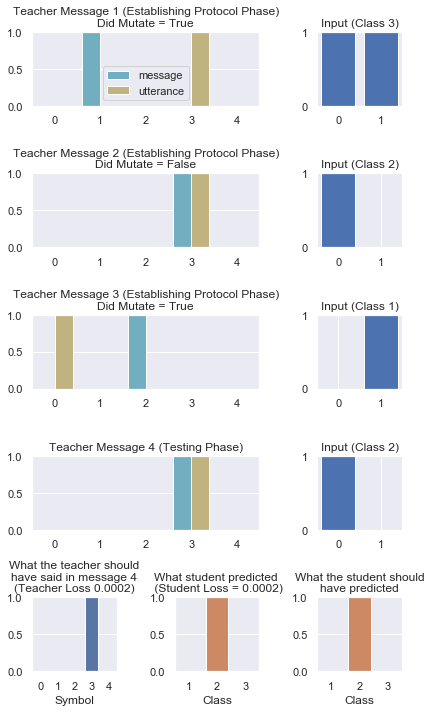

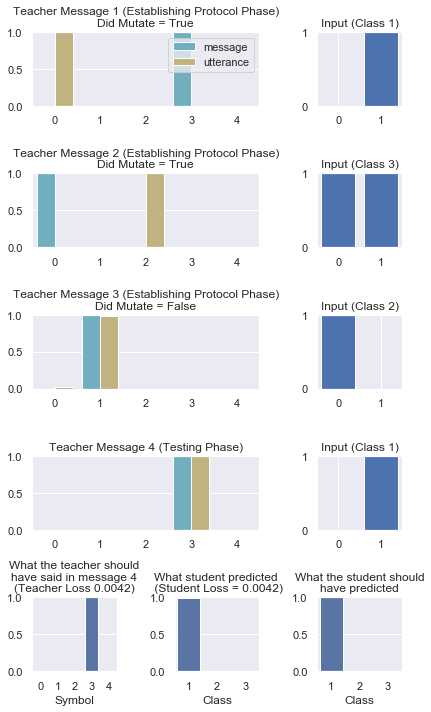

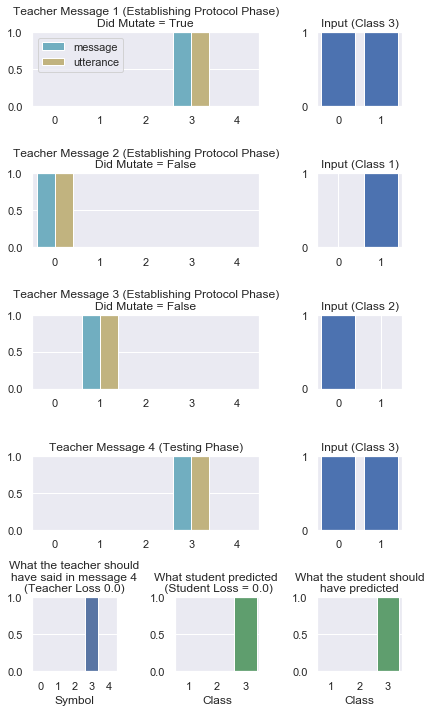

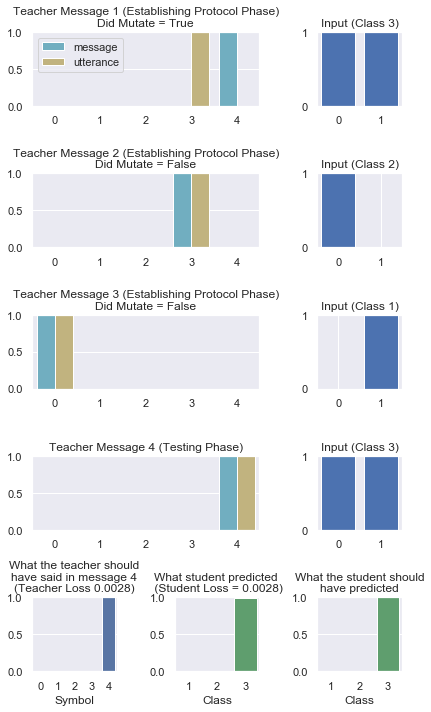

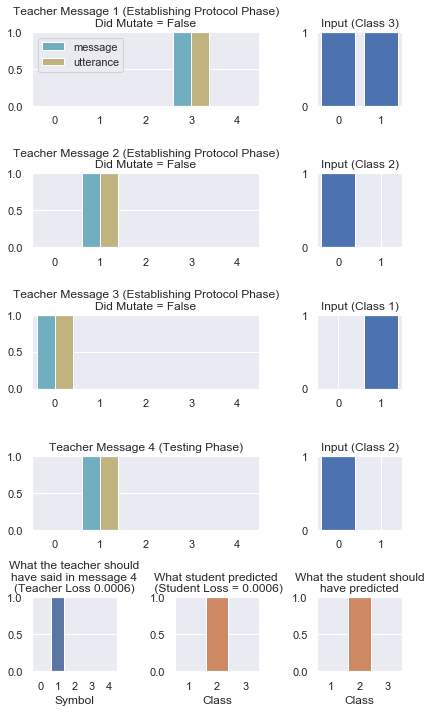

In [33]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=1)

## Zero-shot Coordination

In [42]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment.teacher, 
    experiment2.student, 
    training=False, 
    p_mutate=0,
)

test_metrics = experiment.extract_test_metrics([(inputs, targets, outputs)])
experiment.print_test_metrics(test_metrics)

Test Loss: 1.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 0.0, Protocol Diversity: 1.0, Protocol Entropy: 0.0,


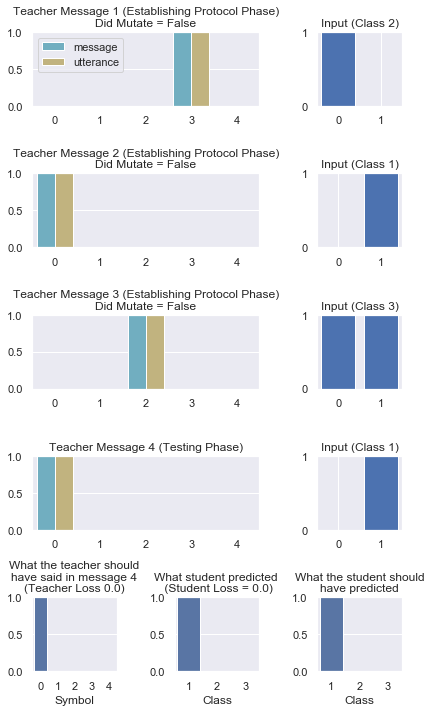

In [49]:
plot_game(inputs, outputs, targets, select_batch=0)

In [50]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment2.teacher, 
    experiment.student, 
    training=False, 
    p_mutate=0,
)

test_metrics = experiment.extract_test_metrics([(inputs, targets, outputs)])
experiment.print_test_metrics(test_metrics)

Test Loss: 4.074, Ground Truth F1-Score: 0.656, Student Error: 2.887, Teacher Error: 0.0, Protocol Diversity: 0.906, Protocol Entropy: 0.03,


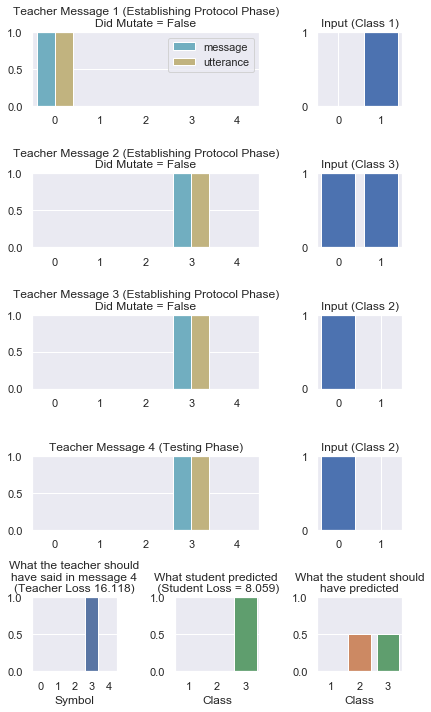

In [57]:
plot_game(inputs, outputs, targets, select_batch=4)

In [87]:
batch_size = 6
channel_size = 5

indices_col = []
for i in range(batch_size):
    idxs = list(range(channel_size))
    random.shuffle(idxs)

    indices_col.append(idxs)
indices_col = tf.convert_to_tensor(indices_col)

indices_row = tf.repeat([list(range(batch_size))], channel_size, axis=0)
indices_row = tf.transpose(indices_row)

permutation_map = tf.stack([indices_row, indices_col], axis=-1)
permutation_map

<tf.Tensor: shape=(6, 5, 2), dtype=int32, numpy=
array([[[0, 3],
        [0, 0],
        [0, 2],
        [0, 4],
        [0, 1]],

       [[1, 0],
        [1, 3],
        [1, 4],
        [1, 2],
        [1, 1]],

       [[2, 0],
        [2, 2],
        [2, 4],
        [2, 3],
        [2, 1]],

       [[3, 0],
        [3, 3],
        [3, 1],
        [3, 4],
        [3, 2]],

       [[4, 4],
        [4, 2],
        [4, 1],
        [4, 3],
        [4, 0]],

       [[5, 2],
        [5, 3],
        [5, 4],
        [5, 0],
        [5, 1]]])>

In [108]:
permutation_subset_size = 2

all_symbols = list(range(channel_size))
inputs = random.sample(all_symbols, permutation_subset_size)
outputs = inputs.copy()
random.shuffle(outputs)

mapping = all_symbols
for i, o in zip(inputs, outputs):
    mapping[i] = o

mapping


[0, 1, 2, 3, 4]

In [133]:
p_c = 0.0

In [134]:
round(p_c * channel_size, 0)

0.0

In [130]:
p_c * channel_size

3.5